# Supply Chain Analytics

- **Problem Statements**: AtliQ Mart is currently facing a problem where a few key customers did not extend their annual contracts due to service issues. It is speculated that some of the essential products were either not delivered on time or not delivered in full over a continued period, which could have resulted in bad customer service.

- **Goals**: 
    1. Identify Problematic Customers and Products
    2. Analyze Factors Contributing to Delivery Service Issues
    3. Provide Recommendations

## 1. Identify Problematic Customers and Products

### 1.1 Read Data from CSV

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import matplotlib.colors as mcolors


In [3]:
df_fact_order_lines = pd.read_csv("dataset & case study\\fact_order_lines.csv")
df_fact_order_aggregate = pd.read_csv("dataset & case study\\fact_orders_aggregate.csv")
df_target = pd.read_csv("dataset & case study\dim_targets_orders.csv")
df_customer = pd.read_csv("dataset & case study\dim_customers.csv")
df_product = pd.read_csv("dataset & case study\dim_products.csv")

### 1.2 Preprocessing Data

#### 1.2.1 Change type of feature data

In [4]:
def turn_datetime(data: pd.DataFrame, columns: list):
    for i in columns:
        data[i] = data[i].astype('datetime64[ns]')

In [5]:
turn_datetime(df_fact_order_lines, ['order_placement_date', 'agreed_delivery_date', 'actual_delivery_date'])
turn_datetime(df_fact_order_aggregate, ['order_placement_date'])

#### 1.2.2 Merge Data

In [6]:
df_merge_aggregate_cust = df_fact_order_aggregate.merge(df_customer, how = 'left', on= 'customer_id')
df_merge_aggregate_cust.head(5)

,order_id,customer_id,order_placement_date,on_time,in_full,otif,customer_name,city
0,FMR32103503,789103,2022-03-01,1,0,0,Vijay Stores,Vadodara
1,FMR34103403,789103,2022-03-01,1,0,0,Vijay Stores,Vadodara
2,FMR32103602,789103,2022-03-01,1,0,0,Vijay Stores,Vadodara
3,FMR33103602,789103,2022-03-01,1,0,0,Vijay Stores,Vadodara
4,FMR33103401,789103,2022-03-01,1,0,0,Vijay Stores,Vadodara


### 1.3.1 Analyze Customer

In [7]:
df_target.head()

,customer_id,ontime_target%,infull_target%,otif_target%
0,789201,87,81,70
1,789202,85,81,69
2,789203,92,76,70
3,789301,89,78,69
4,789303,88,78,69


In [8]:
df_mat = df_merge_aggregate_cust.groupby(['customer_name', 'customer_id'], as_index= False)[['on_time', 'in_full', 'otif']].mean()
df_gap_target = df_mat.merge(df_target, how = 'left', on= 'customer_id')
df_gap_target.head(1)

,customer_name,customer_id,on_time,in_full,otif,ontime_target%,infull_target%,otif_target%
0,Acclaimed Stores,789520,0.298401,0.223801,0.069272,75,68,51


In [9]:
df_cust_mat = df_merge_aggregate_cust.groupby(['customer_name'])[['on_time', 'in_full', 'otif']].mean()

In [10]:
# Compute the gap for each metric
df_gap_target['gap_on_time'] = df_gap_target['on_time'] - df_gap_target['ontime_target%'] * 0.01
df_gap_target['gap_in_full'] = df_gap_target['in_full'] - df_gap_target['infull_target%'] * 0.01
df_gap_target['gap_otif'] = df_gap_target['otif'] - df_gap_target['otif_target%'] * 0.01

In [11]:
df_cust_mat

,on_time,in_full,otif
customer_name,,,
Acclaimed Stores,0.294302,0.523647,0.154701
Atlas Stores,0.718104,0.597813,0.395504
Chiptec Stores,0.716200,0.603532,0.387333
Coolblue,0.291342,0.447271,0.137464
Elite Mart,0.724496,0.379352,0.243739
Expert Mart,0.725407,0.598069,0.391068
Expression Stores,0.699158,0.608303,0.383875
Info Stores,0.709407,0.411624,0.255243
Logic Stores,0.708234,0.601432,0.387828


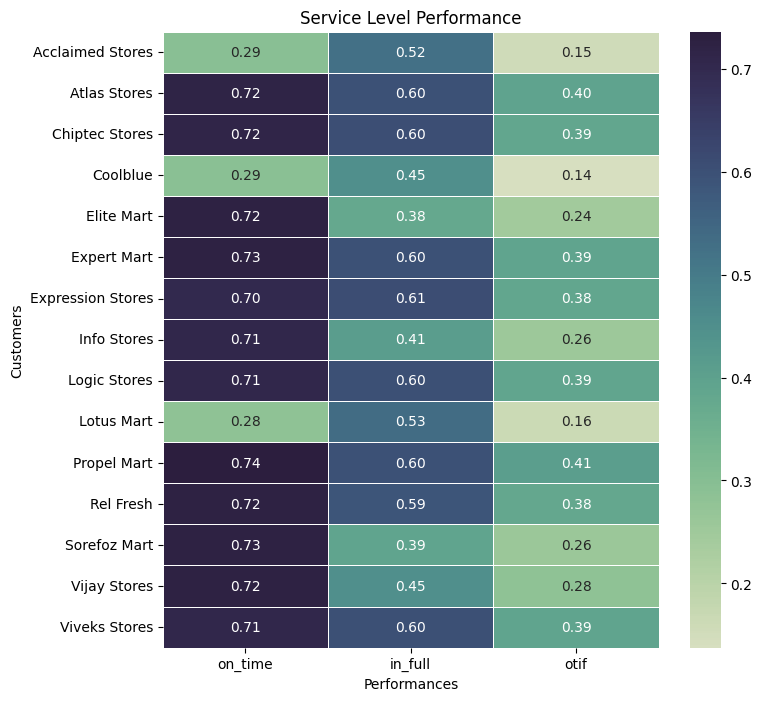

In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_cust_mat, 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), 
            annot=True, 
            fmt='.2f', 
            linewidths=.5)
plt.ylabel('Customers')
plt.xlabel('Performances')
plt.title('Service Level Performance')
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, random_state= 101) 
clusters = kmeans.fit_predict(df_gap_target[['on_time', 'in_full', 'otif','gap_on_time', 'gap_in_full', 'gap_otif']])

# Add cluster labels to the DataFrame
df_gap_target['Cluster'] = clusters

c:\Users\rafly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


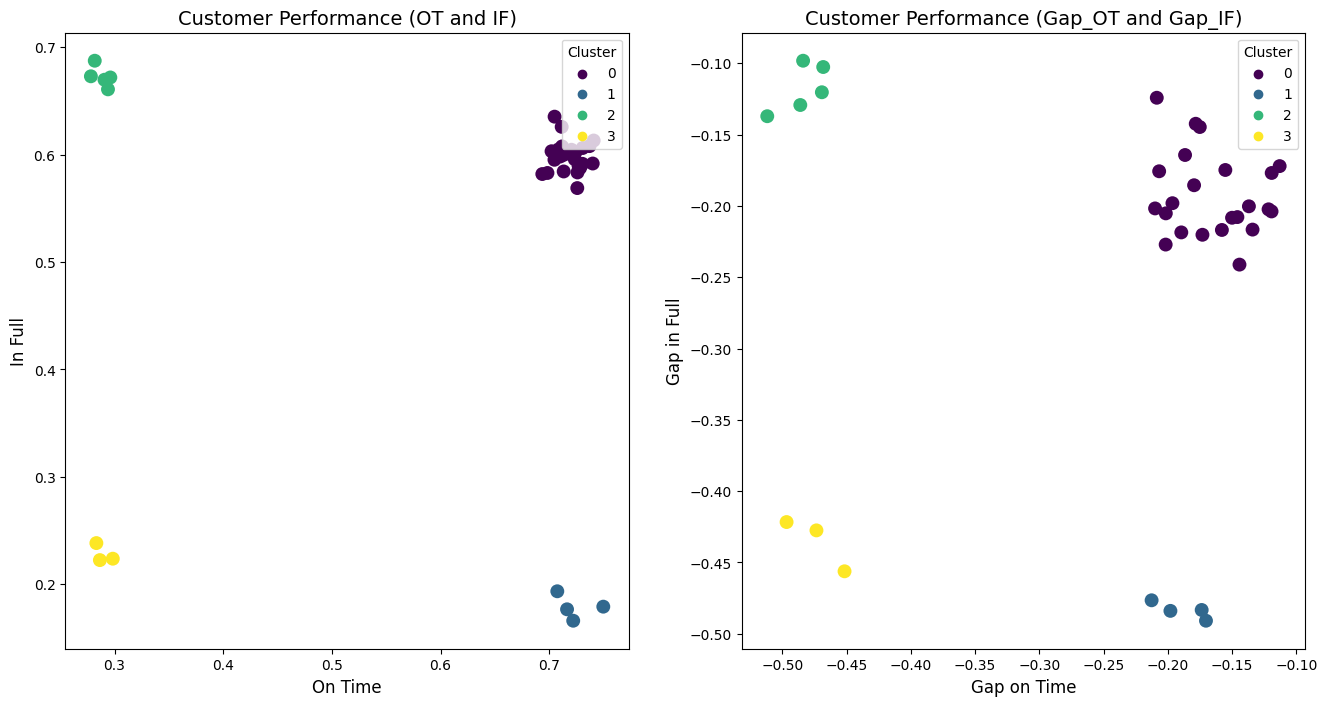

In [14]:
# Create subplots
plt.figure(figsize=(16, 8))

# Subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gap_target, x='on_time', y='in_full', hue='Cluster', palette='viridis', edgecolor='none', s=100)
plt.xlabel('On Time', fontsize=12)
plt.ylabel('In Full', fontsize=12)
plt.title('Customer Performance (OT and IF)', fontsize=14)
plt.legend(title='Cluster', loc='upper right')

# Subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gap_target, x='gap_on_time', y='gap_in_full', hue='Cluster', palette='viridis', edgecolor='none', s=100)
plt.xlabel('Gap on Time', fontsize=12)
plt.ylabel('Gap in Full', fontsize=12)
plt.title('Customer Performance (Gap_OT and Gap_IF)', fontsize=14)
plt.legend(title='Cluster', loc='upper right')

In [15]:
df_gap_target.merge(df_customer, how= 'left', on = 'customer_id')[df_gap_target['Cluster'] == 3]

,customer_name_x,customer_id,on_time,in_full,otif,ontime_target%,infull_target%,otif_target%,gap_on_time,gap_in_full,gap_otif,Cluster,customer_name_y,city
0,Acclaimed Stores,789520,0.298401,0.223801,0.069272,75,68,51,-0.451599,-0.456199,-0.440728,3,Acclaimed Stores,Surat
8,Coolblue,789122,0.286535,0.222496,0.071429,76,65,49,-0.473465,-0.427504,-0.418571,3,Coolblue,Vadodara
20,Lotus Mart,789421,0.283291,0.238338,0.079729,78,66,51,-0.496709,-0.421662,-0.430271,3,Lotus Mart,Ahmedabad


In [16]:
customer_cluster_dict = {}
for cluster in df_gap_target['Cluster'].unique():
    customer_cluster_dict[cluster] = df_gap_target[df_gap_target['Cluster'] == cluster]['customer_id'].unique().tolist()

### Conclusion (Section 1)

- Low Performance in Cluster 3:

    Customers within Cluster 3, including Acclaimed Stores in Surat City, Coolblue in Vadodara City, and Lotus Mart in Ahmedabad City, demonstrate the lowest performance in delivery service metrics.

- On-Time and In-Full Delivery Rates:

    - The on-time delivery percentages for these customers range from approximately 28% to 30%, indicating that only a quarter to a third of orders are delivered on time.
    - Similarly, the in-full delivery percentages range from around 22% to 24%, suggesting that less than a quarter of orders are delivered in full quantity.

- Performance Gap:

    - There exists a noticeable gap between the target performance percentages and the actual delivery performance metrics for these customers.
    - Negative gaps indicate that the actual performance falls below the set targets, highlighting the need for improvement in delivery service to meet customer expectations and target goals.






## 2. Analyze Factors Contributing to Delivery Service Issues

### 2.1 Preprocess data

In [17]:
# Merging Factors Contributing to Delivery Service Issues
df_merge_lines_product = df_fact_order_lines.merge(df_product, how = 'left', on = 'product_id')
df_merge_lines_product_customer = df_merge_lines_product.merge(df_customer, how= 'left', on = 'customer_id')

# mapping custer
def map_cluster(customer_id):
    for cluster, ids in customer_cluster_dict.items():
        if customer_id in ids:
            return cluster
    return None

df_merge_lines_product_customer['cluster'] = df_merge_lines_product_customer['customer_id'].apply(map_cluster)
df_merge_lines_product_customer.head(2)

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,product_name,category,customer_name,city,cluster
0,FMR34203601,2022-03-01,789203,25891601,110,2022-03-04,2022-03-04,110,1,1,1,AM Tea 500,beverages,Rel Fresh,Vadodara,0
1,FMR32320302,2022-03-01,789320,25891203,347,2022-03-02,2022-03-02,347,1,1,1,AM Butter 500,Dairy,Chiptec Stores,Surat,0


### 2.2 Analyze different boxplot/distribution on order_qty

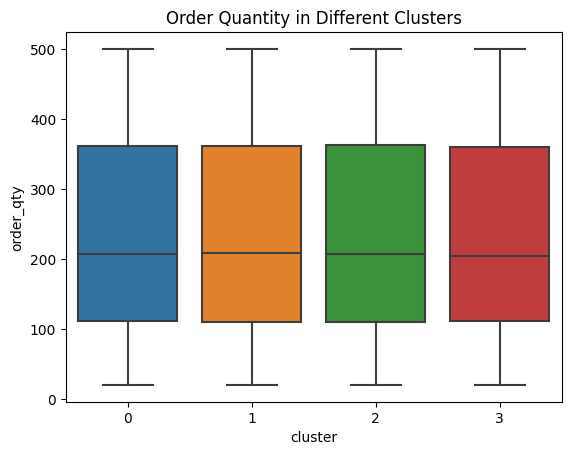

In [18]:
sns.boxplot(df_merge_lines_product_customer, x = 'cluster', y='order_qty')
plt.title('Order Quantity in Different Clusters')
plt.show()

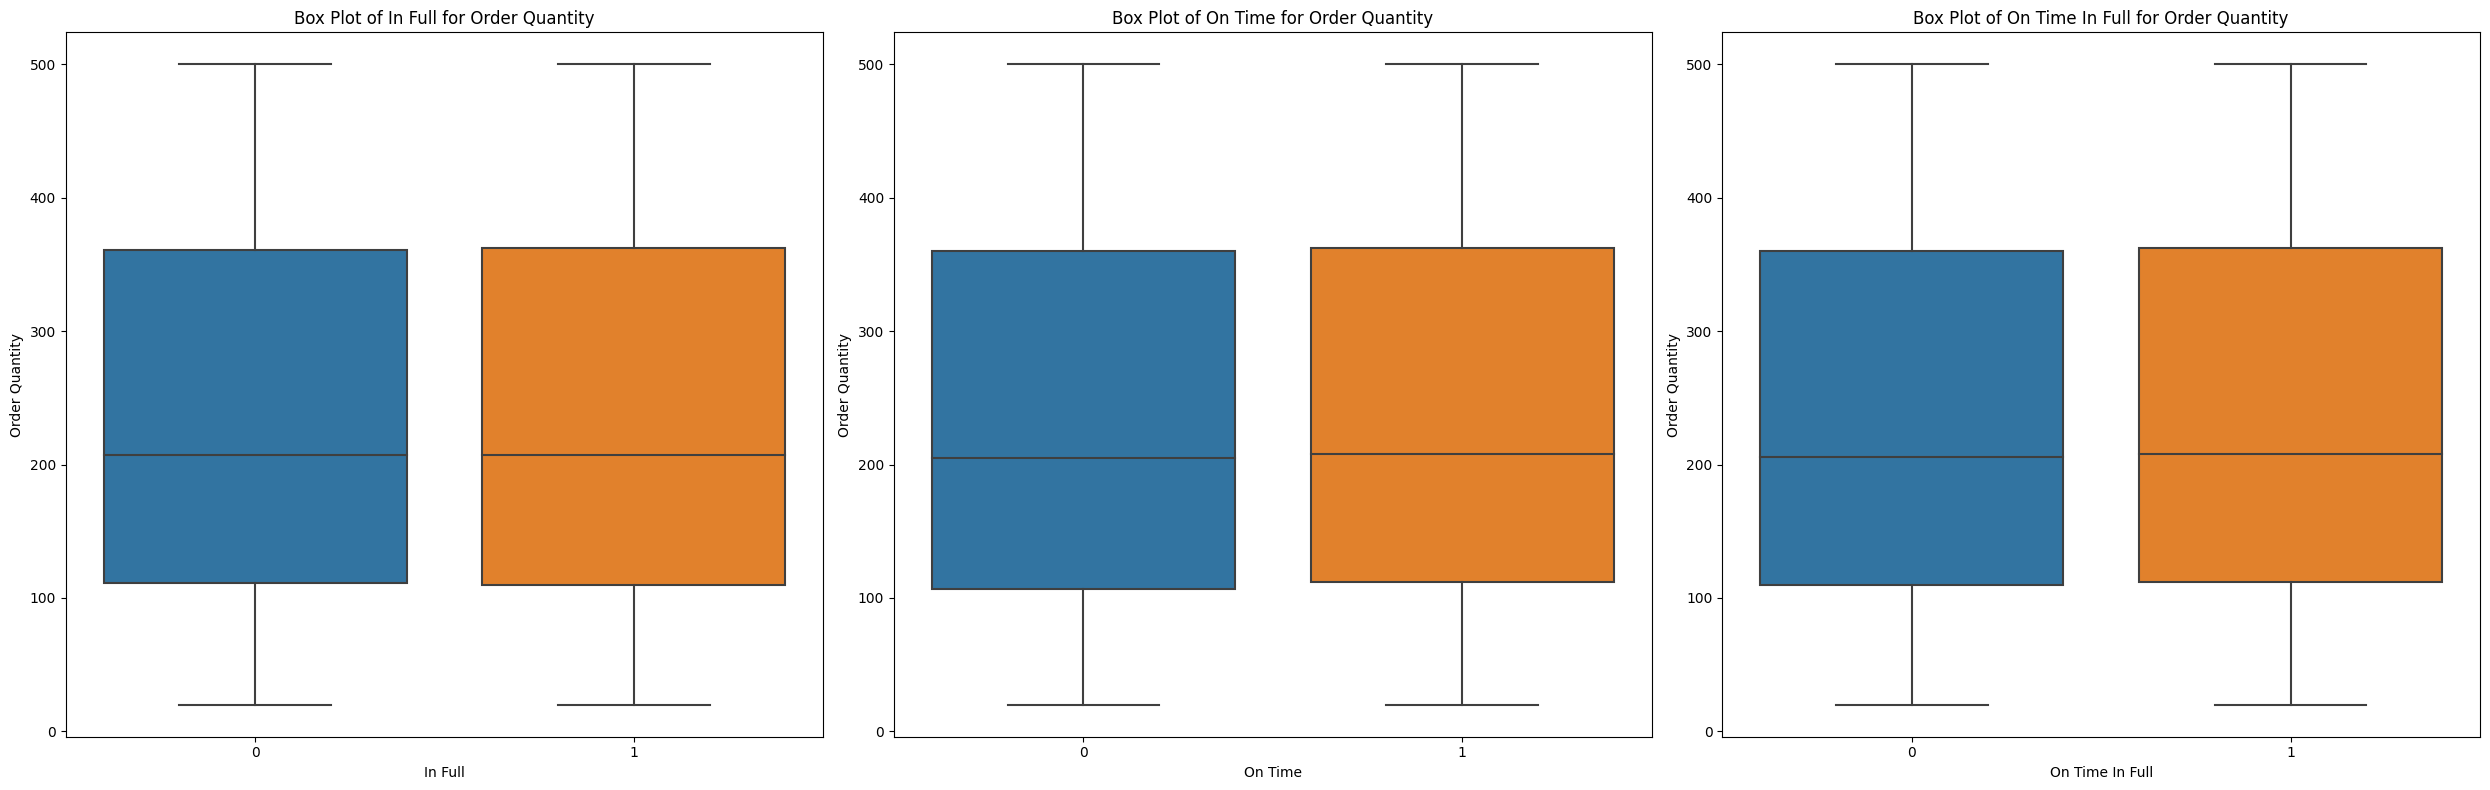

In [19]:
# Box plot IF, OT, and OTIF for order quantity

# Create subplots
plt.figure(figsize=(25, 8))

# Subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(data=df_merge_lines_product_customer, x='In Full', y='order_qty')
plt.title('Box Plot of In Full for Order Quantity')
plt.xlabel('In Full')
plt.ylabel('Order Quantity')

# Subplot 2
plt.subplot(1, 3, 2)
sns.boxplot(data=df_merge_lines_product_customer, x='On Time', y='order_qty')
plt.title('Box Plot of On Time for Order Quantity')
plt.xlabel('On Time')
plt.ylabel('Order Quantity')

# Subplot 3
plt.subplot(1, 3, 3)
sns.boxplot(data=df_merge_lines_product_customer, x='On Time In Full', y='order_qty')
plt.title('Box Plot of On Time In Full for Order Quantity')
plt.xlabel('On Time In Full')
plt.ylabel('Order Quantity')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The boxplot analysis compared order quantity distribution based on delivery performance (OT, IF, OTIF). Results showed no significant difference in median, Q3, Q1, min, and max between orders with full fulfillment versus those without, indicating consistent order quantity distribution regardless of delivery performance.

In [20]:
# Feature Engineering
# Extract year, month, and day
# df_corr['month'] = df_corr['order_placement_date'].dt.month
# df_corr['day'] = df_corr['order_placement_date'].dt.day
# df_corr['day_of_week'] = df_corr['order_placement_date'].dt.dayofweek
# df_corr['quarter'] = df_corr['order_placement_date'].dt.quarter
# df_corr['merging'] = df_corr['city'] + "_" + df_corr['category'] + "_" + df_corr['product_name']  + "_" + df_corr['quarter'].astype(str)

# Calculate the difference between agreed delivery date and order placement date
df_merge_lines_product_customer['order_processing_time'] = (df_merge_lines_product_customer['agreed_delivery_date'] - df_merge_lines_product_customer['order_placement_date']).dt.days

### 2.3 Chi Square Analysis on categorical vs performance variable

In [21]:
# Chi square
def chi_square_test(data, features: list, targets: list):
    dict = {'feature' : features}
    for feature in features:
        for target in targets:
            contingency_table = pd.crosstab(data[feature], data[target])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if target not in dict.keys():
                dict[target] = [p]
            else:
                dict[target].append(p)
    return dict

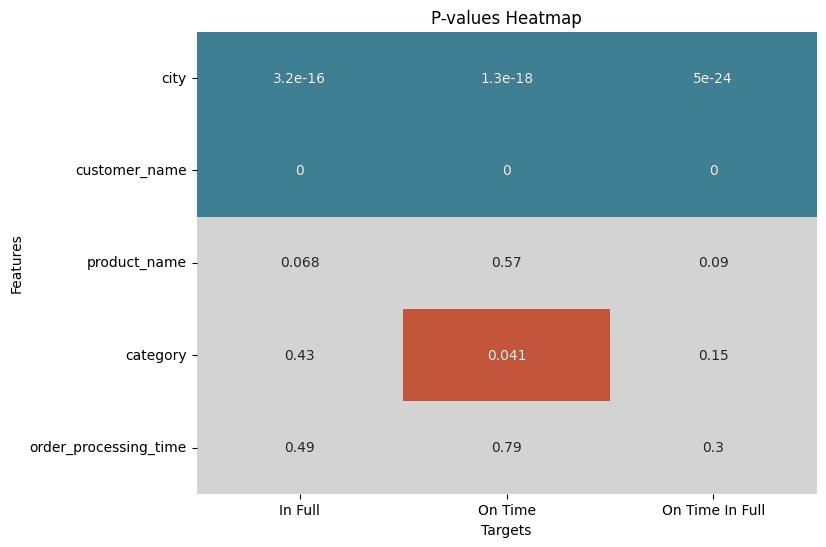

In [22]:
testing = chi_square_test(df_merge_lines_product_customer, ['city','customer_name', 'product_name','category','order_processing_time'], ['In Full', 'On Time','On Time In Full'])
heat_map = pd.DataFrame(testing)
heat_map.set_index('feature', inplace= True)

# Create a mask where values are below 0.05
mask = heat_map < 0.05

# Create a custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create a custom colormap with a single color (gray)
cmap_2 = mcolors.ListedColormap(['lightgray'])

# Create a heatmap with the original data and apply a gray colormap
plt.figure(figsize=(8, 6))
sns.heatmap(heat_map, annot=True, cmap=cmap_2, cbar=False)

# Create a heatmap with the masked data and apply a green-blue colormap
sns.heatmap(heat_map, mask=~mask, annot=True, cmap=cmap, cbar=False)

# Show the plot
plt.title('P-values Heatmap')
plt.xlabel('Targets')
plt.ylabel('Features')
plt.show()

In [23]:
heat_map

,In Full,On Time,On Time In Full
feature,,,
city,3.168635e-16,1.336548e-18,5.037899e-24
customer_name,0.000000e+00,0.000000e+00,0.000000e+00
product_name,6.816929e-02,5.730448e-01,9.036779e-02
category,4.305654e-01,4.125006e-02,1.460033e-01
order_processing_time,4.858138e-01,7.854831e-01,3.022531e-01


The p-values obtained from the chi-square test for various features indicate the significance of their association with delivery performance metrics (In Full, On Time, On Time In Full):

1. City and Customer Name: Both city and customer name show extremely low p-values (close to 0), suggesting a highly significant association with all delivery performance variable.

2. Product Name: While the association of product name with delivery performance varies across metrics, it shows moderate significance for some metrics, particularly In Full and On Time In Full.

3. Category: The product category also demonstrates a significant association with On Time Performance.

### 2.4 Make Simple Analysis on Cross tab

In [24]:
chi2_contingency(pd.crosstab(df_merge_lines_product_customer['city'], df_merge_lines_product_customer['In Full']))

Chi2ContingencyResult(statistic=71.37612101715936, pvalue=3.168635264706114e-16, dof=2, expected_freq=array([[ 6697.54553734, 12978.45446266],
       [ 6073.26730419, 11768.73269581],
       [ 6664.18715847, 12913.81284153]]))

In [32]:
# Create contingency table
contingency_table = pd.crosstab(df_merge_lines_product_customer['city'], df_merge_lines_product_customer['On Time'], margins=True)


# Perform chi-square test
chi2, p, _, expected_counts = chi2_contingency(contingency_table)

# Calculate percentages within rows
percentages_within_rows = (contingency_table.T / contingency_table['All']).T * 100

# Create DataFrame for expected counts
expected_df = pd.DataFrame(expected_counts, index = contingency_table.index, columns = contingency_table.columns)

# Combine contingency table and percentages within rows
cross_tab = pd.concat([contingency_table, percentages_within_rows, expected_df], keys=['Observed', 'Row Percentages', 'Expected'])

cross_tab = cross_tab.swaplevel(0, 1, axis=0).sort_index().reindex(['Ahmedabad', 'Surat', 'Vadodara', 'All'], level = 0)

# Display the cross-tabulation
cross_tab

On Time                               0             1      All
city                                                          
Ahmedabad Expected          5683.006095  13992.993905  19676.0
          Observed          5902.000000  13774.000000  19676.0
          Row Percentages     29.995934     70.004066    100.0
Surat     Expected          5153.293085  12688.706915  17842.0
          Observed          4698.000000  13144.000000  17842.0
          Row Percentages     26.331129     73.668871    100.0
Vadodara  Expected          5654.700820  13923.299180  19578.0
          Observed          5891.000000  13687.000000  19578.0
          Row Percentages     30.089897     69.910103    100.0
All       Expected         16491.000000  40605.000000  57096.0
          Observed         16491.000000  40605.000000  57096.0
          Row Percentages     28.882934     71.117066    100.0

### 2.5 Export Data to be used in SPSS

In [27]:
df_merge_lines_product_customer[['city', 'customer_name', 'On Time','In Full', 'On Time In Full']].to_csv('dataset & case study/chi.csv')